In [77]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import lightgbm as lgb
import warnings

warnings.filterwarnings("ignore")

In [86]:
df = pd.read_csv('iyzico_data.csv',index_col=0)
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid
0,2018-01-01,535,349,25883.226
1,2018-01-01,42616,141,40918.860
2,2018-01-01,46774,410,306902.700
3,2018-01-01,86302,10,11.340
4,2018-01-01,124381,285,111383.766


In [87]:
df['transaction_date'] = pd.to_datetime(df['transaction_date'])

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7667 entries, 0 to 7666
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   transaction_date   7667 non-null   datetime64[ns]
 1   merchant_id        7667 non-null   int64         
 2   Total_Transaction  7667 non-null   int64         
 3   Total_Paid         7667 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 299.5 KB


In [89]:
print(f"Verisetinin Başlangıç Tarihi : {df.transaction_date.min()} , Verisetinin Bitiş Tarihi : {df.transaction_date.max()}")

Verisetinin Başlangıç Tarihi : 2018-01-01 00:00:00 , Verisetinin Bitiş Tarihi : 2020-12-31 00:00:00


In [90]:
print(f"Üye İş Yerlerinin İd'leri  : {df.merchant_id.unique()} , Toplam Üye İş Yeri Sayısı: {df.merchant_id.nunique()} ")


Üye İş Yerlerinin İd'leri  : [   535  42616  46774  86302 124381 129316  57192] , Toplam Üye İş Yeri Sayısı: 7 


In [91]:
df.groupby("merchant_id").agg({"Total_Paid": "sum"})

,Total_Paid
merchant_id,
535,1.566015e+08
42616,3.545831e+08
46774,1.567200e+09
57192,3.173371e+08
86302,2.870447e+06
124381,1.158693e+09
129316,1.555471e+06


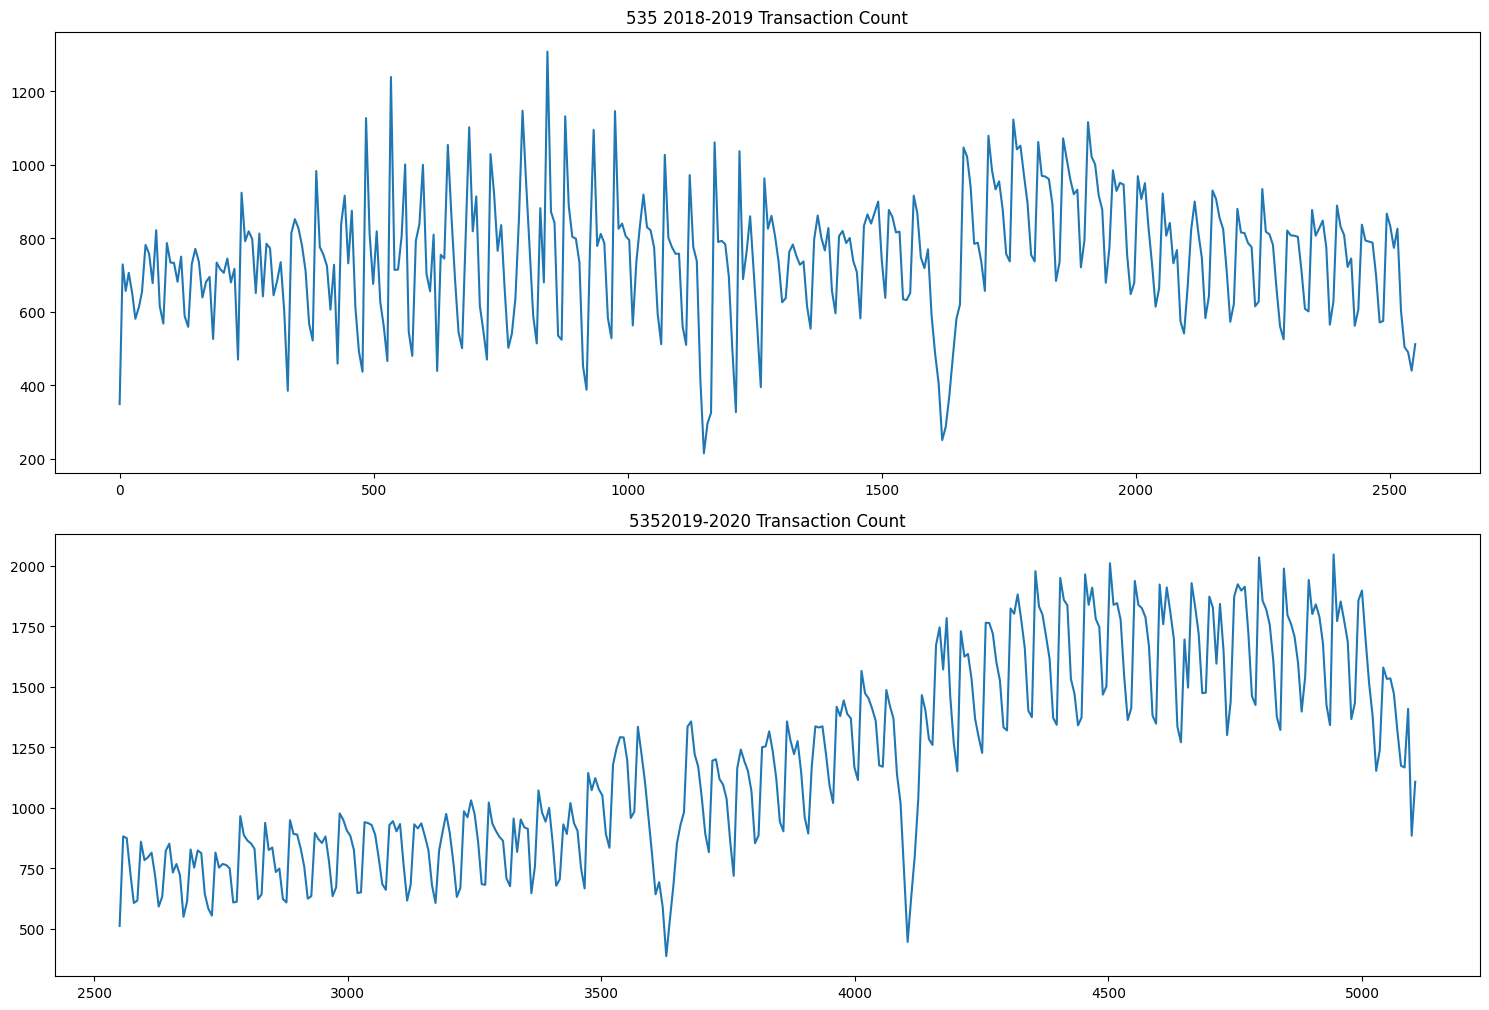

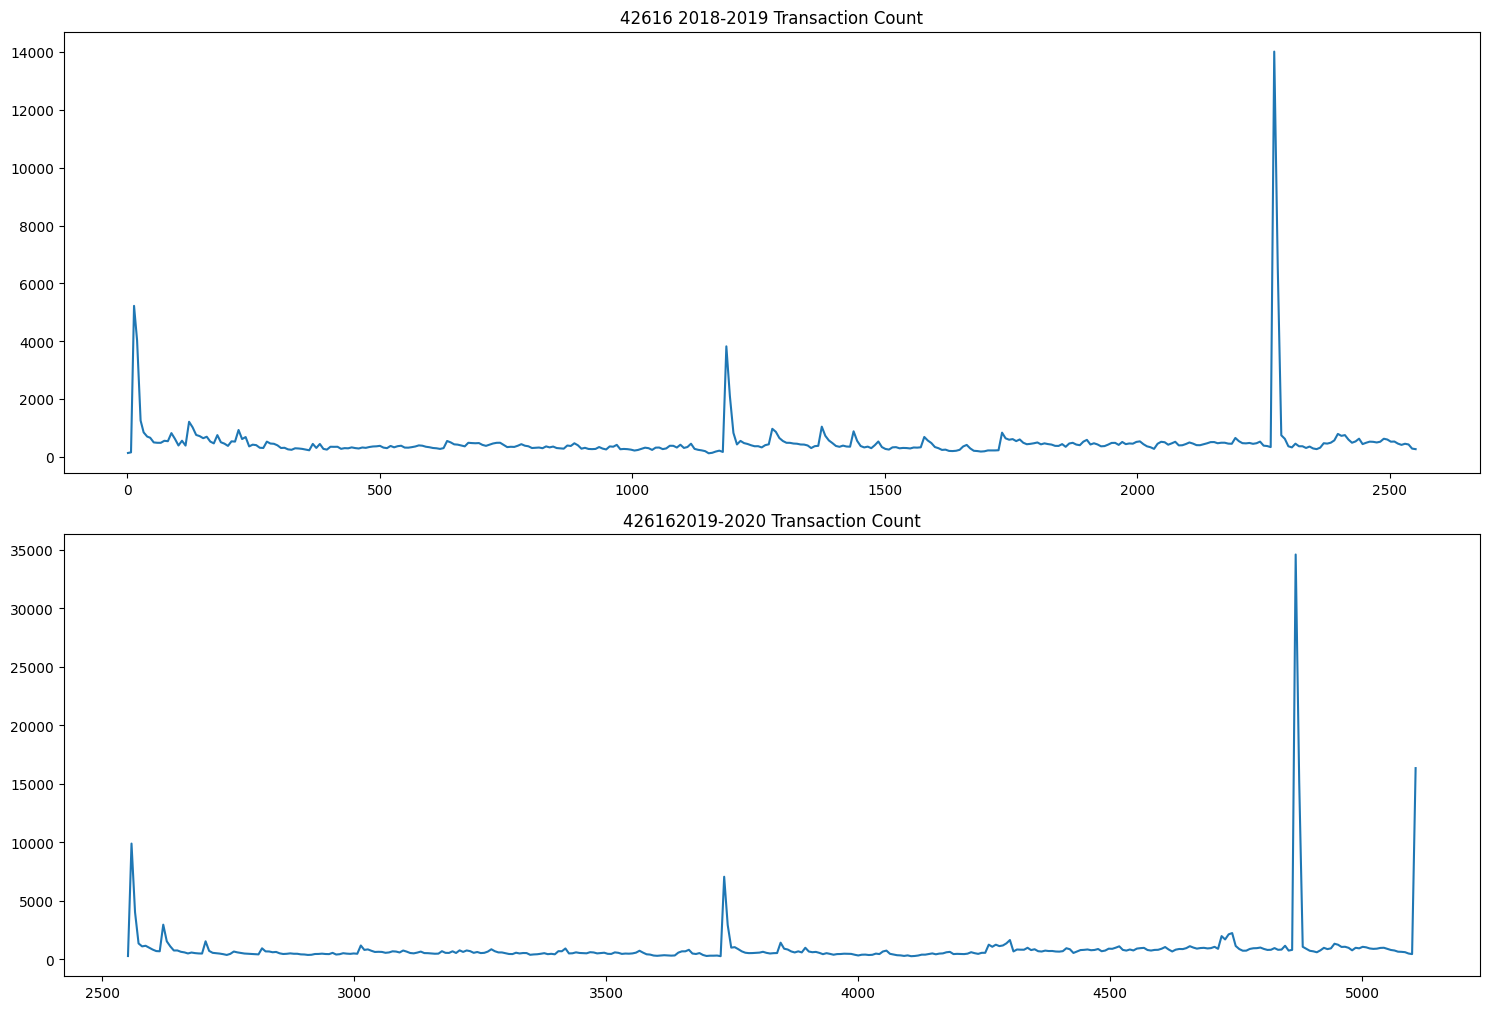

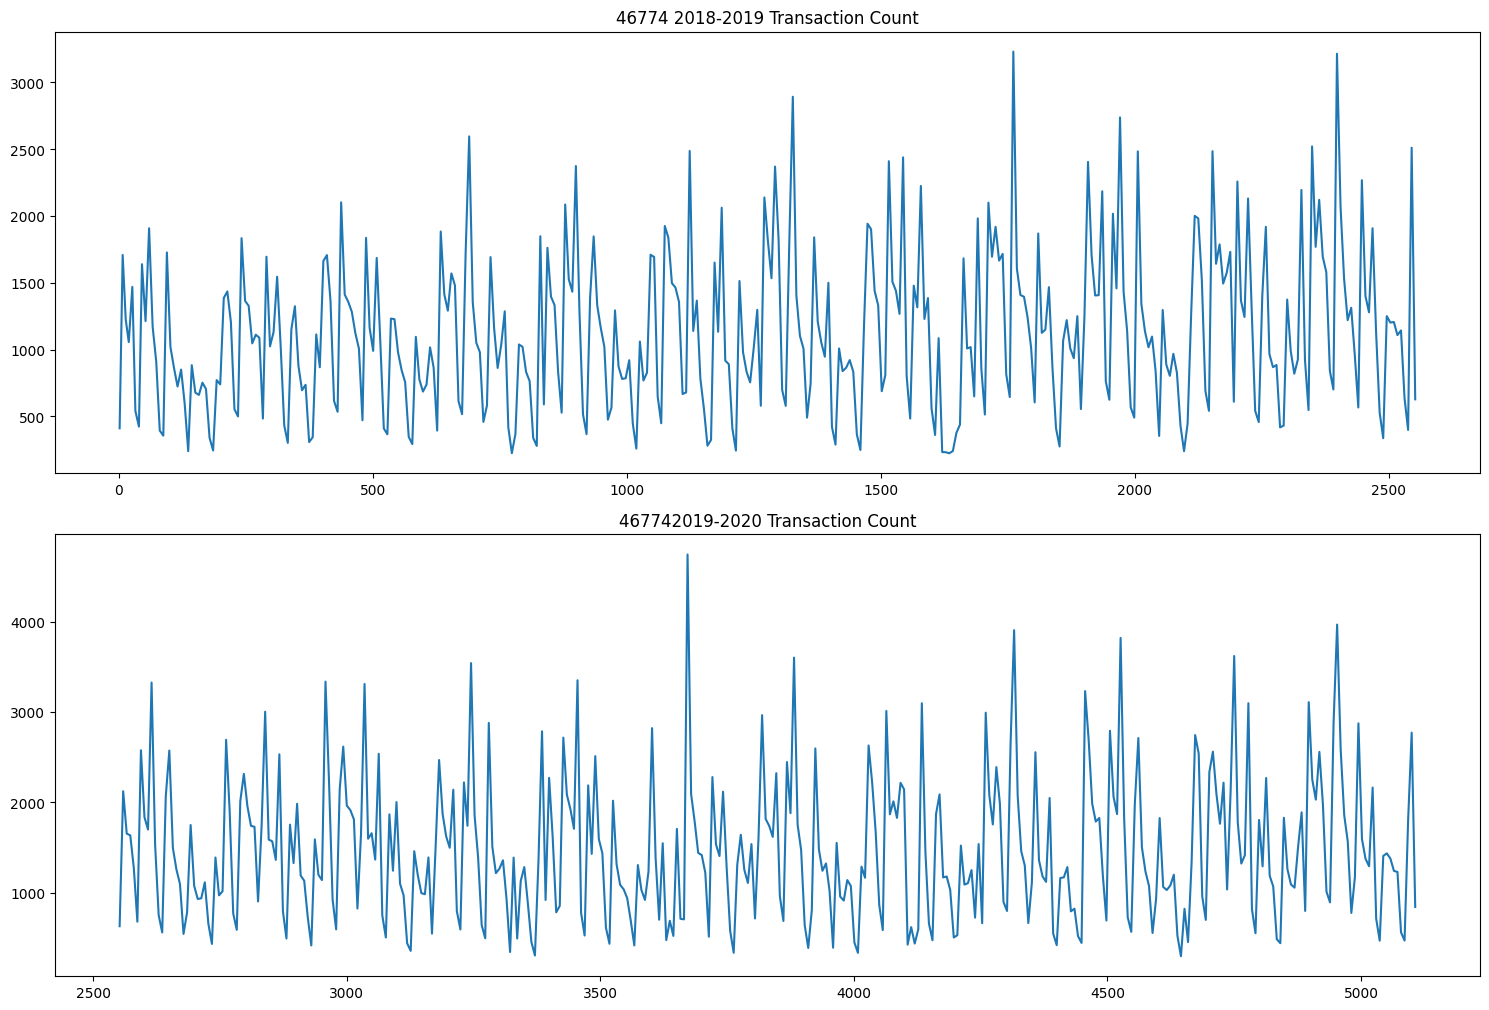

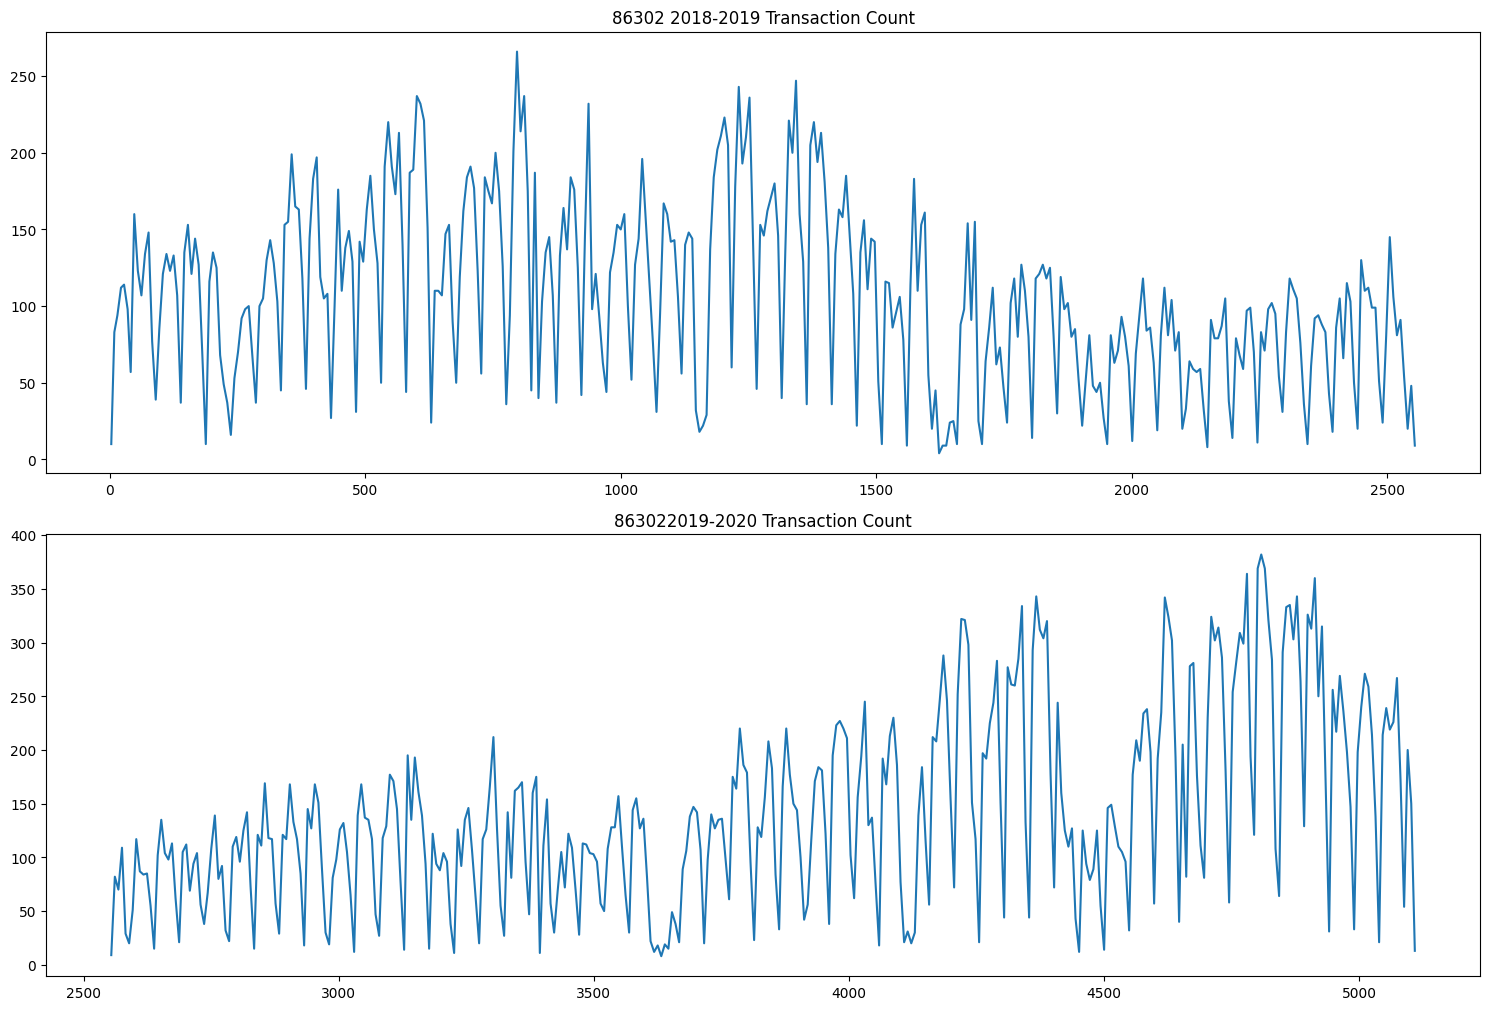

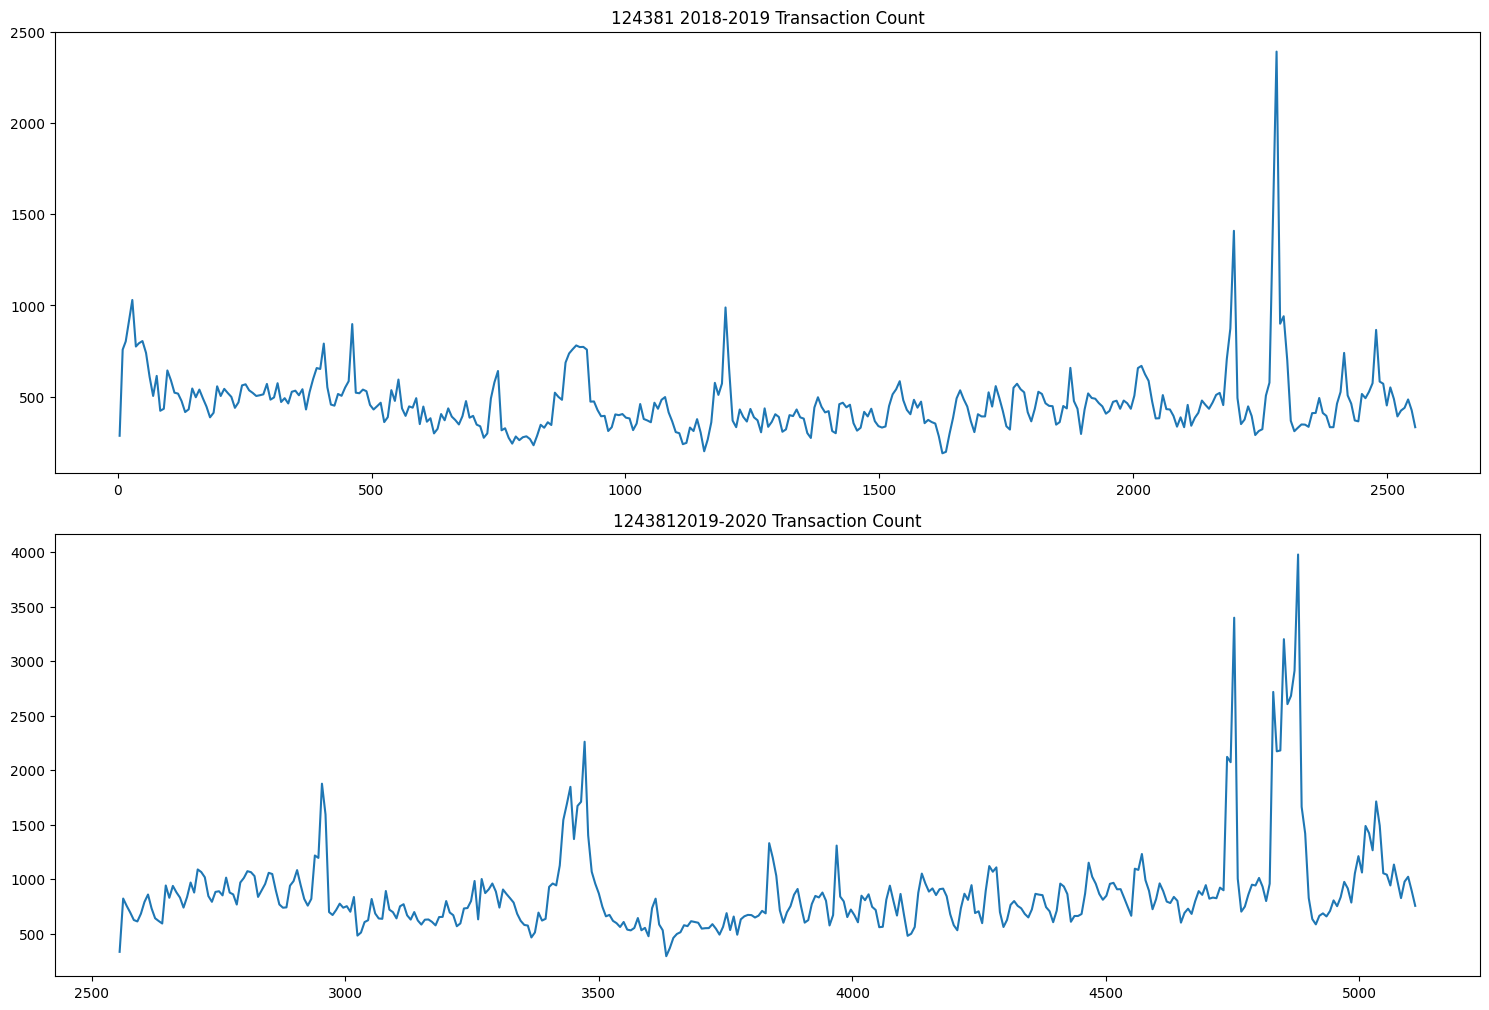

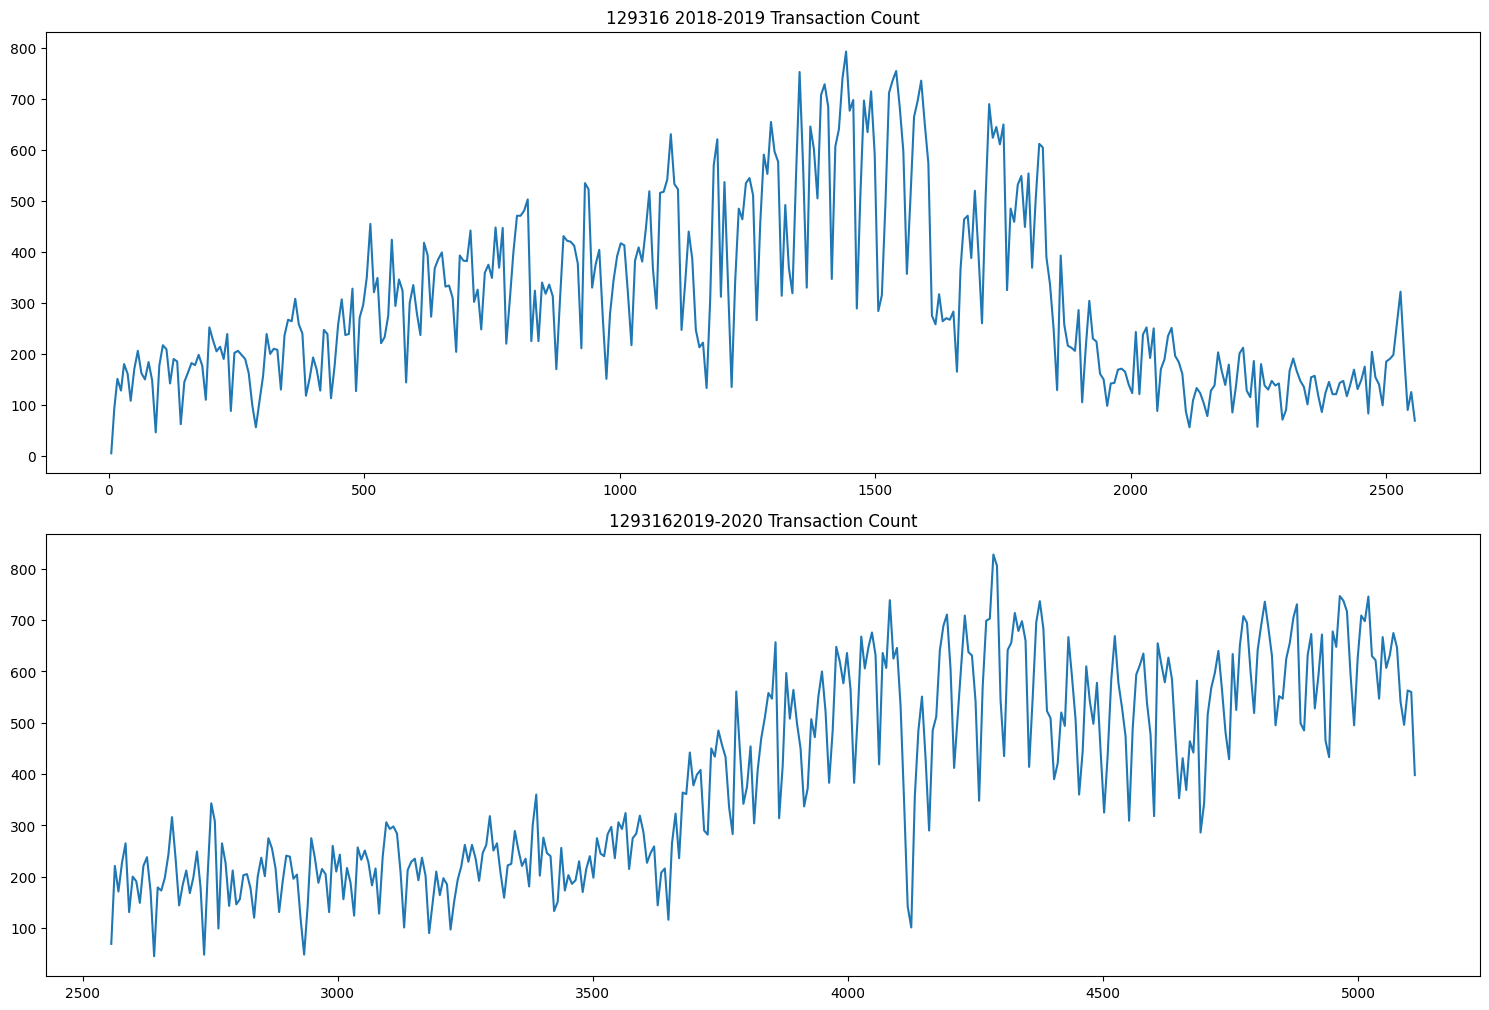

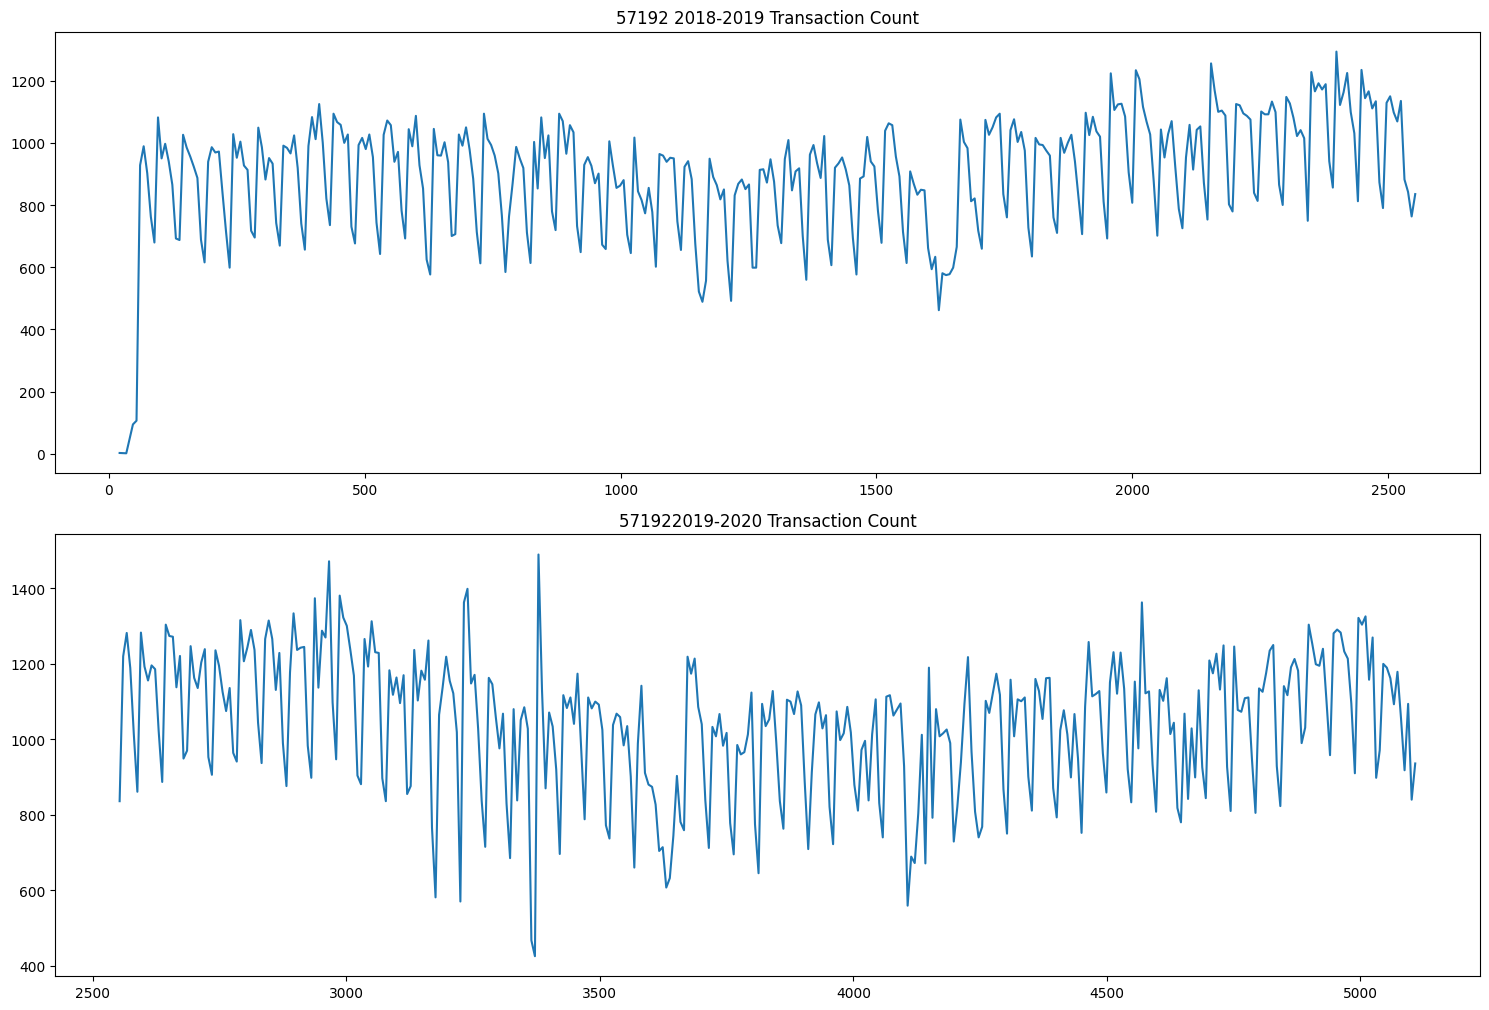

In [92]:
for id in df.merchant_id.unique():
    plt.figure(figsize=(15,15))
    plt.subplot(3, 1, 1, title= str(id) + " 2018-2019 Transaction Count") 
    df[(df.merchant_id == id) & (df.transaction_date >= "2018-01-01") &  (df.transaction_date <= "2019-01-01")]['Total_Transaction'].plot()
    plt.xlabel('')
    plt.subplot(3, 1, 2, title= str(id) + "2019-2020 Transaction Count") 
    df[(df.merchant_id == id) & (df.transaction_date >= "2019-01-01") &  (df.transaction_date <= "2020-01-01")]['Total_Transaction'].plot()
    plt.xlabel('')
    plt.tight_layout()
    plt.show()


In [93]:
def create_date_features(df, date_column):
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.isocalendar().week
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

In [94]:
df = create_date_features(df, "transaction_date")

In [95]:
def random_noise(dataframe):
    return np.random.normal(scale=1.6, size=(len(dataframe),))

def lag_features(dataframe, lags):
    for lag in lags:
        dataframe['sales_lag_' + str(lag)] = dataframe.groupby(["merchant_id"])['Total_Transaction'].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

In [96]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe['sales_roll_mean_' + str(window)] = dataframe.groupby("merchant_id")['Total_Transaction']. \
                                                          transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(
            dataframe)
    return dataframe

df = roll_mean_features(df, [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])

In [97]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby("merchant_id")['Total_Transaction'].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)

In [98]:
df["is_black_friday"] = 0
df.loc[df["transaction_date"].isin(["2018-11-22","2018-11-23","2019-11-29","2019-11-30"]) ,"is_black_friday"]=1

df["is_summer_solstice"] = 0
df.loc[df["transaction_date"].isin(["2018-06-19","2018-06-20","2018-06-21","2018-06-22",
                                    "2019-06-19","2019-06-20","2019-06-21","2019-06-22",]) ,"is_summer_solstice"]=1

In [99]:
df.head()

,transaction_date,merchant_id,Total_Transaction,Total_Paid,month,day_of_month,day_of_year,week_of_year,day_of_week,year,...,sales_ewm_alpha_05_lag_451,sales_ewm_alpha_05_lag_539,sales_ewm_alpha_05_lag_540,sales_ewm_alpha_05_lag_541,sales_ewm_alpha_05_lag_629,sales_ewm_alpha_05_lag_630,sales_ewm_alpha_05_lag_631,sales_ewm_alpha_05_lag_720,is_black_friday,is_summer_solstice
0,2018-01-01,535,349,25883.226,1,1,1,1,0,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,2018-01-01,42616,141,40918.860,1,1,1,1,0,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
2,2018-01-01,46774,410,306902.700,1,1,1,1,0,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
3,2018-01-01,86302,10,11.340,1,1,1,1,0,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
4,2018-01-01,124381,285,111383.766,1,1,1,1,0,2018,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [100]:
df = pd.get_dummies(df, columns=['merchant_id','day_of_week', 'month'],dtype=int)
df['Total_Transaction'] = np.log1p(df["Total_Transaction"].values)

In [101]:
df

,transaction_date,Total_Transaction,Total_Paid,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,5.857933,25883.226,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,4.955827,40918.860,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-01,6.018593,306902.700,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-01,2.397895,11.340,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2018-01-01,5.655992,111383.766,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7662,2020-12-31,8.130059,3174751.332,31,366,53,2020,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7663,2020-12-31,6.753438,337696.020,31,366,53,2020,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7664,2020-12-31,7.885329,10461.006,31,366,53,2020,0,0,1,...,0,0,0,0,0,0,0,0,0,1
7665,2020-12-31,8.207674,2445655.950,31,366,53,2020,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [104]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num / denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels = train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return 'SMAPE', smape_val, False

In [105]:
import re
df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df.head()

,transaction_date,Total_Transaction,Total_Paid,day_of_month,day_of_year,week_of_year,year,is_wknd,is_month_start,is_month_end,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,2018-01-01,5.857933,25883.226,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2018-01-01,4.955827,40918.860,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2018-01-01,6.018593,306902.700,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2018-01-01,2.397895,11.340,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2018-01-01,5.655992,111383.766,1,1,1,2018,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [106]:
train = df.loc[(df["transaction_date"] < "2020-10-01"), :]

val = df.loc[(df["transaction_date"] >= "2020-10-01"), :]

In [107]:
cols = [col for col in train.columns if col not in ['transaction_date', 'id', "Total_Transaction","Total_Paid", "year" ]]

Y_train = train['Total_Transaction']
X_train = train[cols]

Y_val = val['Total_Transaction']
X_val = val[cols]

In [108]:
Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((7023,), (7023, 212), (644,), (644, 212))

In [114]:
lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}



In [120]:
lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

In [127]:
model = lgb.train(
    lgb_params,
    lgbtrain,
    valid_sets=[lgbtrain, lgbval],
    num_boost_round=lgb_params['num_boost_round'],
    feval=lgbm_smape,
    callbacks=[
        lgb.early_stopping(stopping_rounds=lgb_params['early_stopping_rounds']),
        lgb.log_evaluation(period=100)
)

Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.296802	training's SMAPE: 28.4455	valid_1's l1: 0.28674	valid_1's SMAPE: 27.4084
[200]	training's l1: 0.242871	training's SMAPE: 23.4962	valid_1's l1: 0.230777	valid_1's SMAPE: 22.262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[300]	training's l1: 0.221741	training's SMAPE: 21.544	valid_1's l1: 0.214394	valid_1's SMAPE: 20.7653
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furth

In [128]:
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

In [135]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

np.float64(20.581289206524307)

In [130]:
def plot_lgb_importances(model, plot=False, num=10):

    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))

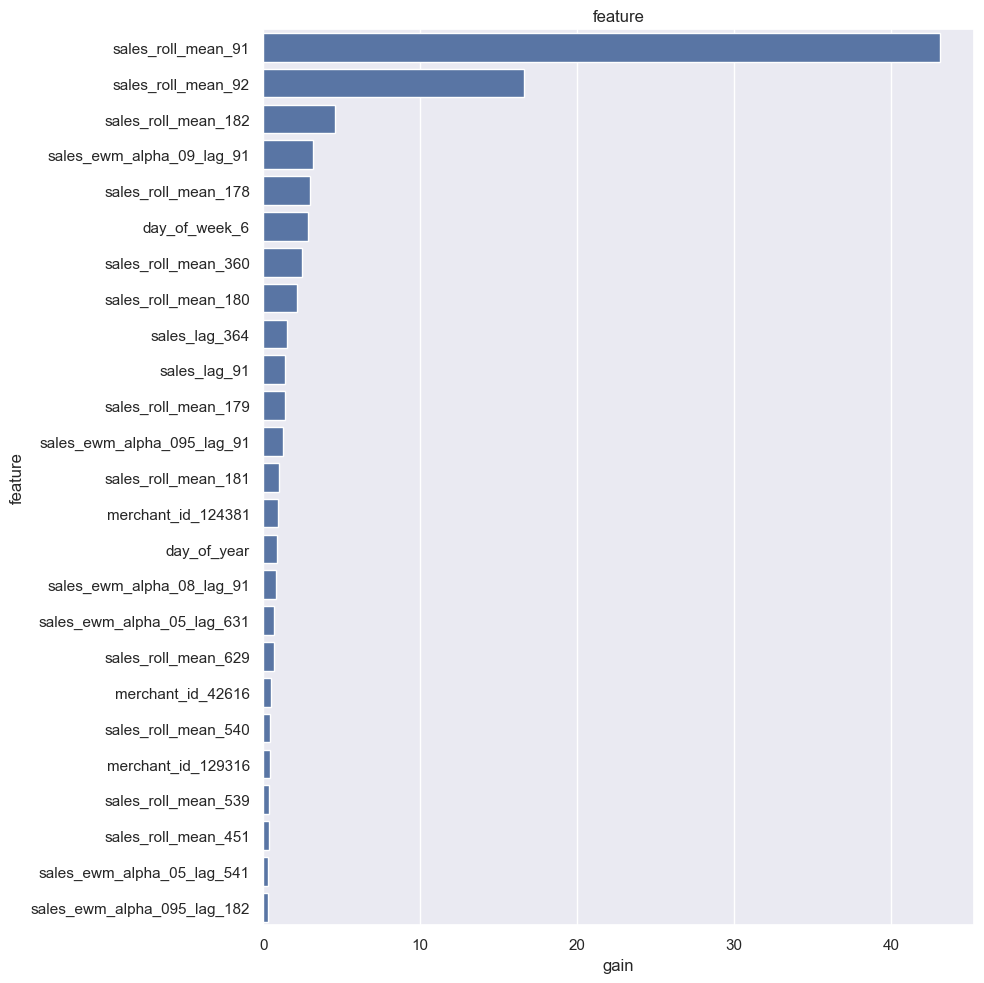

In [131]:
plot_lgb_importances(model, num=30, plot=True)

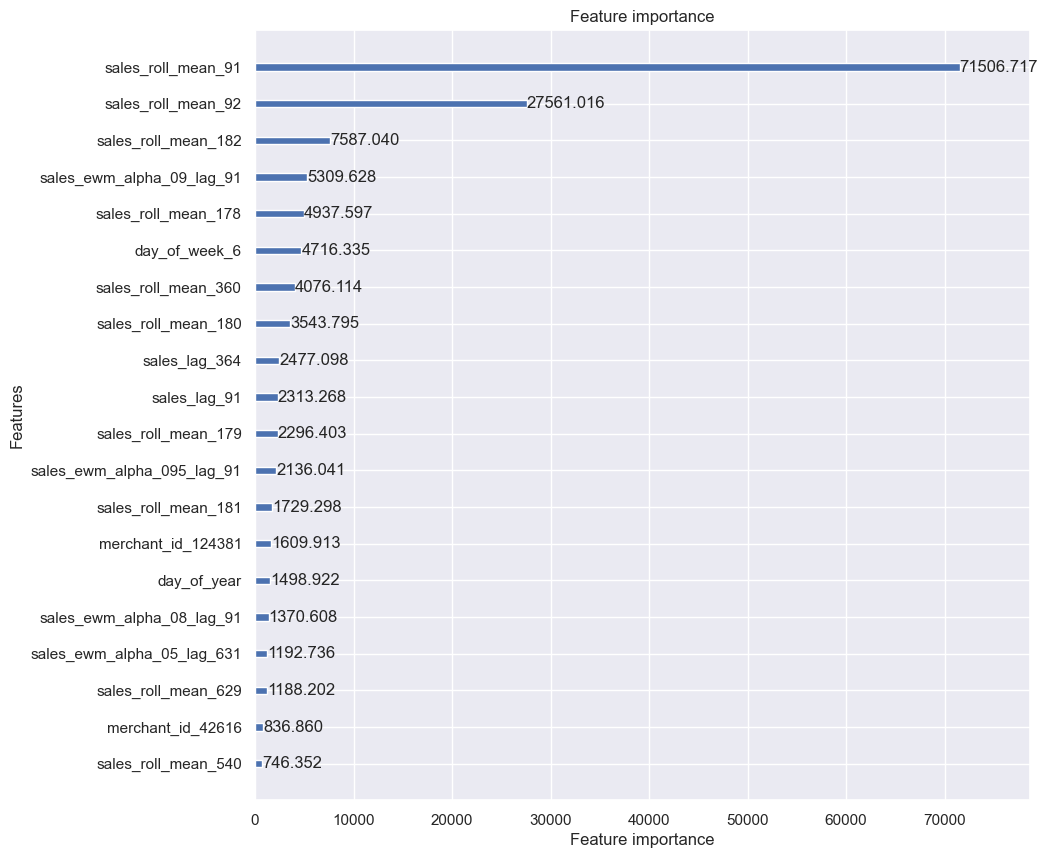

In [132]:
lgb.plot_importance(model, max_num_features=20, figsize=(10, 10), importance_type="gain")
plt.show()